## Density maps

In [1]:
import h5py
import scipy.io as io
import PIL.Image as Image
import numpy as np
import os
import glob
from matplotlib import pyplot as plt
import scipy
import json
from matplotlib import cm as CM
#from model import CSRNet
#import torch
%matplotlib inline

from tqdm import tqdm
import PIL
import cv2
import random
import math
import sys
import pandas as pd

import numpy as np

from __future__ import print_function

from itertools import chain
import zipfile

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from linformer import Linformer
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from tqdm.notebook import tqdm

from vit_pytorch.vit import ViT
#from vit_pytorch.efficient import ViT
from vit_pytorch.recorder import Recorder

In [2]:
torch.__version__

'1.11.0'

In [25]:


# Training settings
batch_size = 1
epochs = 100
lr = 3e-5
gamma = 0.7
seed = 42

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(seed)

device = 'cuda'


train_transforms = transforms.Compose(
    [
        #transforms.Resize((512, 512)),
        transforms.ToTensor(),
    ]
)

In [26]:
#set the root to the Shanghai dataset you download
root = 'ShanghaiTech_Crowd_Counting_Dataset/'

#now generate the ShanghaiA's ground truth
part_A_train = os.path.join(root,'part_A_final/train_data','images')
part_A_test = os.path.join(root,'part_A_final/test_data','images')
part_B_train = os.path.join(root,'part_B_final/train_data','images')
part_B_test = os.path.join(root,'part_B_final/test_data','images')
path_sets = [part_A_train,part_A_test]
path_sets

['ShanghaiTech_Crowd_Counting_Dataset/part_A_final/train_data\\images',
 'ShanghaiTech_Crowd_Counting_Dataset/part_A_final/test_data\\images']

In [27]:
img_paths = []
for path in path_sets:
    for img_path in glob.glob(os.path.join(path, '*.jpg')):
        img_paths.append(img_path)
print(len(img_paths))

482


In [28]:
print(img_paths[0].replace('.jpg','.h5').replace('images','new_gt'))

ShanghaiTech_Crowd_Counting_Dataset/part_A_final/train_data\new_gt\IMG_1.h5


(64, 64)


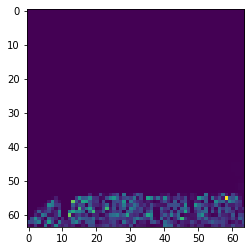

In [29]:
def get_output(path):
    #import target
    #resize target
    
    gt_file = h5py.File(path,'r')
    
    target = np.asarray(gt_file['density'])
    #print(target.shape)
    
    img = cv2.resize(target,(int(target.shape[1]/8),int(target.shape[0]/8)),interpolation = cv2.INTER_CUBIC)*64
    
    #print("target shape :", target.shape)
    #print("output shape :", img.shape)
    
    #img = np.expand_dims(img,axis  = 2)
    
    #print(img.shape)
    
    return img

print(get_output(img_paths[0].replace('.jpg','.h5').replace('images','new_gt')).shape)
plt.imshow(get_output(img_paths[0].replace('.jpg','.h5').replace('images','new_gt')))

In [30]:
train_paths = [paths for paths in img_paths if 'train_data' in paths]
test_paths = [paths for paths in img_paths if 'test_data' in paths]

In [31]:
len(train_paths)

300

In [32]:
train, valid = train_test_split(train_paths,test_size=0.2,random_state=seed)

print(len(train))
print(len(valid))

240
60


In [33]:
class load_dataset(Dataset):
    def __init__(self, file_list, transform=None):
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        self.filelength = len(self.file_list)
        return self.filelength

    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path).convert('RGB')
        img = np.array(img)
        img = cv2.resize(img, (512,512))
        
        img=img/255.0
        img = np.reshape(img, (3,512,512))
        #img_transformed = self.transform(img)
        img_transformed = torch.tensor(img)
        #print(img.shape, img_transformed.shape, img_path)

        label = get_output(img_paths[idx].replace('.jpg','.h5').replace('images','new_gt'))

        return img_transformed, label

In [34]:
train_data = load_dataset(train, transform=train_transforms)
valid_data = load_dataset(valid, transform=train_transforms)
test_data = load_dataset(test_paths, transform=train_transforms)

train_loader = DataLoader(dataset = train_data, batch_size=batch_size, shuffle=True, generator=torch.Generator(device='cuda'))
valid_loader = DataLoader(dataset = valid_data, batch_size=batch_size, shuffle=True, generator=torch.Generator(device='cuda'))
test_loader = DataLoader(dataset = test_data, batch_size=batch_size, shuffle=True, generator=torch.Generator(device='cuda'))

In [35]:
print(len(train_data), len(train_loader))

240 240


In [36]:
train_data[0][0].shape

torch.Size([3, 512, 512])

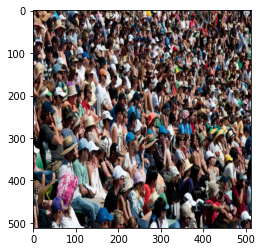

In [37]:
plt.imshow(np.reshape(train_data[0][0].cpu().detach().numpy(),(512,512,3)))

In [38]:
class ViT_density(nn.Module):
    def __init__(self):
        super(ViT_density, self).__init__()
        self.vit = ViT(
                    image_size = 512,
                    patch_size = 8,
                    num_classes = 1,
                    dim = 128,#1024
                    depth = 3,#6
                    heads = 8,#16
                    mlp_dim = 128,#1024
                    dropout = 0.1,
                    emb_dropout = 0.1
                )
        self.recorder = Recorder(self.vit)
        # deconvolution layers
        self.conv_block = nn.Sequential(
            nn.ConvTranspose2d(257, 32, kernel_size=9, stride=1),
            nn.ConvTranspose2d(32, 32, kernel_size=6, stride=2),
            #nn.ConvTranspose2d(257, 128, kernel_size=6, stride=1),
            #nn.ConvTranspose2d(128, 128, kernel_size=6, stride=1),
            #nn.ConvTranspose2d(128, 64, kernel_size=6, stride=1),
            nn.ConvTranspose2d(32, 32, kernel_size=5, stride=1),
            nn.ConvTranspose2d(32, 32, kernel_size=5, stride=1),
            nn.ConvTranspose2d(32, 32, kernel_size=5, stride=1),
            nn.ConvTranspose2d(32, 32, kernel_size=1, stride=1)
        )

        # Conv layers
        self.conv_block = nn.Sequential(
            nn.Conv2d(32, 128, (3, 3), padding='same', dilation=2),
            nn.Conv2d(128, 128, (3, 3), padding='same', dilation=2),
            nn.Conv2d(128, 64, (3, 3), padding='same', dilation=2),
            #nn.Conv2d(128, 64, (3, 3), padding='same', dilation=2),
            #nn.Conv2d(64, 64, (3, 3), padding='same', dilation=2),
            nn.Conv2d(64, 64, (3, 3), padding='same', dilation=2),
            nn.Conv2d(64, 1, (3, 3), padding='same', dilation=1)
        )

        # model.add(Conv2D(512, (3, 3), activation='relu', dilation_rate = 2, kernel_initializer = init, padding = 'same'))
        # model.add(Conv2D(512, (3, 3), activation='relu', dilation_rate = 2, kernel_initializer = init, padding = 'same'))
        # model.add(Conv2D(512, (3, 3), activation='relu', dilation_rate = 2, kernel_initializer = init, padding = 'same'))
        # model.add(Conv2D(256, (3, 3), activation='relu', dilation_rate = 2, kernel_initializer = init, padding = 'same'))
        # model.add(Conv2D(128, (3, 3), activation='relu', dilation_rate = 2, kernel_initializer = init, padding = 'same'))
        # model.add(Conv2D(64, (3, 3), activation='relu', dilation_rate = 2, kernel_initializer = init, padding = 'same'))
        # model.add(Conv2D(1, (1, 1), activation='relu', dilation_rate = 1, kernel_initializer = init, padding = 'same'))

    def forward(self, x, train=True):
        batch_size = x.shape[0]
        #x = self.vit(x)
        x = x.float()
        self.preds, self.attns = self.recorder(x)
        #print(self.attns.shape)

        #attn_heatmap = attns[:,-1,-1, :, 1:].reshape((batch_size,257,16, 16))#.detach().cpu().numpy()
        #[batch size, depth, heads, rows, w, h]
        attn_heatmap = self.attns[:,-1,-1,:,1:].view((batch_size,257,16,16))
        #print(type(attn_heatmap))
        
        x = self.conv_block(attn_heatmap)
        #print(x.shape, type(x))

        if not train:
            return x, self.attns
        
        return x
    
    def attns(self):
        return self.attns

In [39]:
model = ViT_density().to(device)
#img = torch.randn(batch_size,3, 512, 512).to(device)
#x = model(img)
#print(x.shape)

In [40]:
from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params+=params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params
    
count_parameters(model)

+-----------------------------------------------+------------+
|                    Modules                    | Parameters |
+-----------------------------------------------+------------+
|               vit.pos_embedding               |   524416   |
|                 vit.cls_token                 |    128     |
|        vit.to_patch_embedding.1.weight        |   24576    |
|         vit.to_patch_embedding.1.bias         |    128     |
|     vit.transformer.layers.0.0.norm.weight    |    128     |
|      vit.transformer.layers.0.0.norm.bias     |    128     |
|  vit.transformer.layers.0.0.fn.to_qkv.weight  |   196608   |
| vit.transformer.layers.0.0.fn.to_out.0.weight |   65536    |
|  vit.transformer.layers.0.0.fn.to_out.0.bias  |    128     |
|     vit.transformer.layers.0.1.norm.weight    |    128     |
|      vit.transformer.layers.0.1.norm.bias     |    128     |
|   vit.transformer.layers.0.1.fn.net.0.weight  |   16384    |
|    vit.transformer.layers.0.1.fn.net.0.bias   |    12

1732930

In [41]:
torch.set_default_tensor_type('torch.cuda.FloatTensor')

In [42]:
def euclidean_distance_loss(y_true, y_pred):
    # Euclidean distance as a measure of loss (Loss function) 
    return torch.sqrt(torch.sum(torch.square(y_pred - y_true)))

In [43]:
# loss function
#criterion = nn.MSELoss()
# optimizer
optimizer = optim.SGD(model.parameters(), lr=1e-7, weight_decay=(5*1e-4), momentum=0.95)
#optimizer = optim.Adam(model.parameters(), lr=lr)
# scheduler
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

In [44]:
el = []
ea = []
evl = []
eva = []

In [45]:
torch.cuda.is_available()

True

In [46]:
for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0

    for data, label in tqdm(train_loader):
        if len(data)==batch_size:
            data = data.to(device)
            label = label.to(device)

            output = model(data)
            #loss = criterion(output, label)
            loss = euclidean_distance_loss(output, label)
            

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            #output = output.cpu()
            mae = torch.abs(output-label).float().mean()
            epoch_accuracy += mae / len(train_loader)
            epoch_loss += loss / len(train_loader)
    #print(epoch_accuracy, epoch_loss, mae)

    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in valid_loader:
            if len(data)==batch_size:
                data = data.to(device)
                label = label.to(device)

                val_output = model(data)
                #val_loss = criterion(val_output, label)
                val_loss = euclidean_distance_loss(val_output, label)

                mae = torch.abs(val_output-label).float().mean()
                #acc = (val_output.argmax(dim=1) == label).float().mean()
                epoch_val_accuracy += mae / len(valid_loader)
                epoch_val_loss += val_loss / len(valid_loader)
    
    el.append(epoch_loss)
    ea.append(epoch_accuracy)
    evl.append(epoch_val_loss)
    eva.append(epoch_val_accuracy)
    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )

  0%|          | 0/240 [00:00<?, ?it/s]

RuntimeError: CUDA out of memory. Tried to allocate 514.00 MiB (GPU 0; 6.00 GiB total capacity; 5.03 GiB already allocated; 0 bytes free; 5.06 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

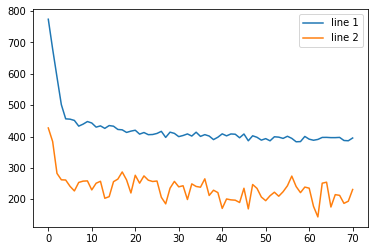

In [ ]:
el = [e.cpu().detach().numpy() for e in el]
evl = [e.cpu().detach().numpy() for e in evl]

plt.plot(range(len(el)),el, label = "line 1")
plt.plot(range(len(el)),evl, label = "line 2")
plt.legend()
plt.show()

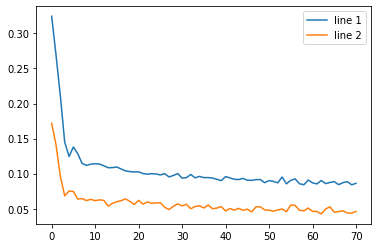

In [ ]:
ea = [e.cpu().detach().numpy() for e in ea]
eva = [e.cpu().detach().numpy() for e in eva]

plt.plot(range(len(ea)),ea, label = "line 1")
plt.plot(range(len(ea)),eva, label = "line 2")
plt.legend()
plt.show()

In [ ]:
torch.save(model.state_dict(), 'drive/MyDrive/torch_models/vit_density.pth')

In [ ]:
model.load_state_dict(torch.load('drive/MyDrive/torch_models/vit_density.pth'))

<All keys matched successfully>

In [ ]:
def create_img(path):
    #Function to load,normalize and return image 
    img = Image.open(img_path).convert('RGB')
    img = np.array(img)
    img = cv2.resize(img, (512,512))
    
    img=img/255.0
    img = np.reshape(img, (3,512,512))
    #img_transformed = self.transform(img)
    img_transformed = torch.tensor(img)
    return img_transformed

def predict(path, model):
    #mod = model.cpu()
    #Function to load image,predict heat map, generate count and return (count , image , heat map)
    #model = load_model()
    image = create_img(path)
    print("image shape :",image.shape)

    image = image.unsqueeze(0).to(device)
    print("image shape :",image.shape)
    ans, attns = model(image, train=False)
    count = np.sum(ans.cpu().detach().numpy())
    return image,ans, count, attns

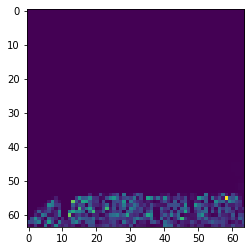

In [ ]:
path = "drive/MyDrive/ShanghaiTech_Crowd_Counting_Dataset/part_A_final/train_data/new_gt/IMG_1.h5"
path = path.replace('.h5','.jpg').replace('new_gt','images')
output = get_output(path.replace('.jpg','.h5').replace('images','new_gt') )
plt.imshow(output)

image shape : torch.Size([3, 512, 512])
image shape : torch.Size([1, 3, 512, 512])
251.8778
572.0321
251.87779599428177


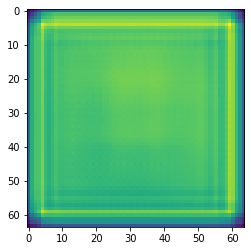

In [ ]:
image,ans,count, attns = predict(path,model)
print(count)
print(np.sum(output))
an = ans[0].cpu().detach().numpy()
an = np.reshape(an,(64,64))
print(sum(sum(an)))
plt.imshow(an)

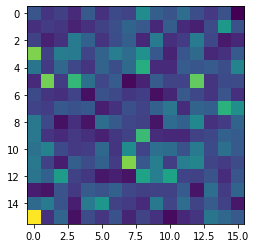

In [ ]:
attn_heatmap = attns[:,-1,-1,:,1:]
attn_heatmap = attn_heatmap.cpu().detach().numpy()
attn_heatmap = np.reshape(attn_heatmap,(1,257,16,16))

plt.imshow(attn_heatmap[0][0])

(1, 3, 512, 512)


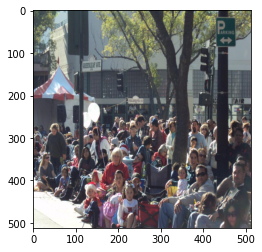

In [ ]:
print(image.cpu().detach().numpy().shape)
plt.imshow(np.reshape(image[0].cpu().detach().numpy(),(512,512,3)))